#  Data Preparation

## Libraries

In [ ]:
!pip install adjustText

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from adjustText import adjust_text
from scipy.stats import pearsonr
from tabulate import tabulate

## Data Reading and Cleaning

In [ ]:
data = pd.read_excel("/content/Store_Sales_Summary.xlsx")


In [ ]:
# Column Cleaning
data.columns = data.columns.str.strip().str.replace('\xa0', '', regex=False)
data.dropna(how='all', inplace=True)

# Month Cleaning
data['Month'] = data['Month'].astype(str).str.strip().str.capitalize()

# Defining month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Applying categorical sort
data['Month'] = pd.Categorical(data['Month'], categories=month_order, ordered=True)
data = data.sort_values('Month')

data = data[data['Month'].notna()]

print("Final Cleaned Data:")

# Feature Engineering
data['Customer_Growth (%)'] = ((data['Current Year Customers'] - data['Last Year Customers']) /
                                data['Last Year Customers']) * 100


print(data[['Month', 'Total Sales (₹ Lakhs)']])
print("Total rows:", len(data))


Final Cleaned Data:
        Month  Total Sales (₹ Lakhs)
0     January                  78.47
1    February                  68.82
2       March                  78.94
3       April                  72.92
4         May                  81.22
5        June                  75.34
6        July                  80.61
7      August                  76.50
8   September                  74.89
9     October                  93.72
10   November                  63.58
11   December                  55.47
Total rows: 12


# Sales Forecasting and Temporal Dynamics

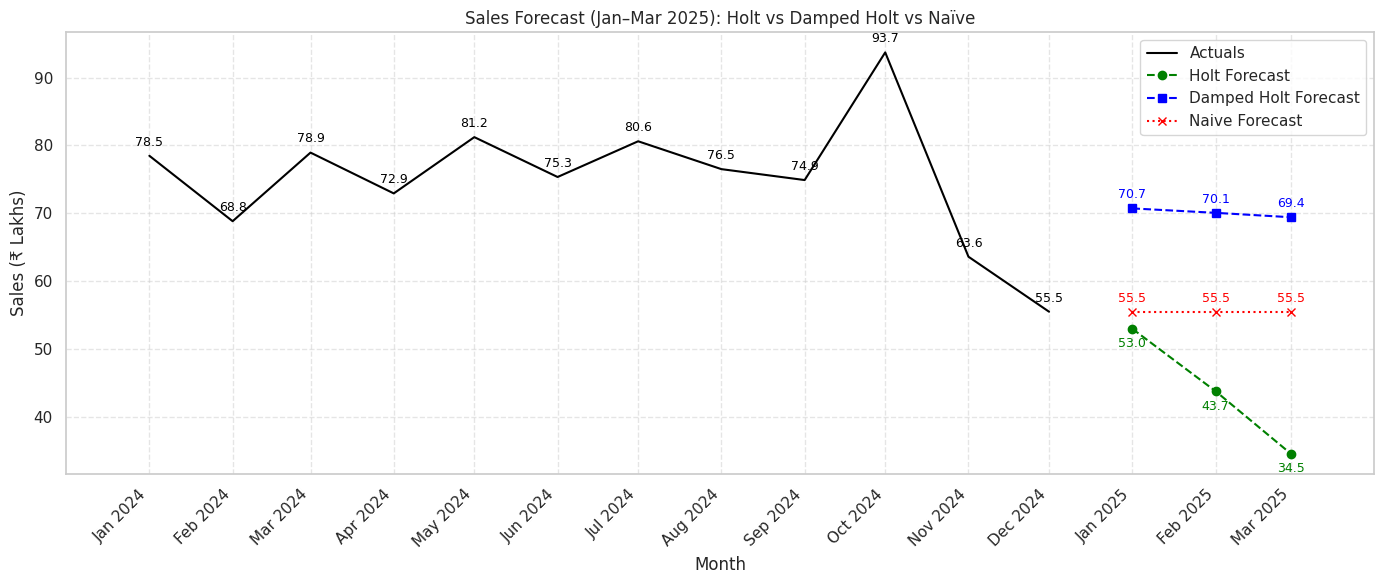


 Forecast Comparison Table:
|    | Month         |   Holt Forecast (₹ Lakhs) |   Damped Holt Forecast (₹ Lakhs) |   Naive Forecast (₹ Lakhs) |
|----|---------------|---------------------------|----------------------------------|----------------------------|
|  0 | January 2025  |                     52.95 |                            70.71 |                      55.47 |
|  1 | February 2025 |                     43.74 |                            70.06 |                      55.47 |
|  2 | March 2025    |                     34.53 |                            69.41 |                      55.47 |

 % Change from Dec 2024:
|    | Month         |   % Change from Dec (Holt) |   % Change from Dec (Damped) |   % Change from Dec (Naive) |
|----|---------------|----------------------------|------------------------------|-----------------------------|
|  0 | January 2025  |                      -4.54 |                        27.47 |                           0 |
|  1 | February 2025 |         

/tmp/ipython-input-58-3471785544.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dec_val = sales_series[-1]


In [ ]:
# Figure 1- Sales Forecast Comparison (Holt, Damped Holt and Naïve)

# Step 1: Cleaning and preparing Month column
data['Month'] = data['Month'].astype(str).str.strip().str.capitalize()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
data['Month'] = pd.Categorical(data['Month'], categories=month_order, ordered=True)
data = data.sort_values('Month')

# Step 2: Cleaning Total Sales column
# Removal of non-numeric characters and conversion to float
data['Total Sales (₹ Lakhs)'] = data['Total Sales (₹ Lakhs)'].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
data['Total Sales (₹ Lakhs)'] = pd.to_numeric(data['Total Sales (₹ Lakhs)'], errors='coerce')

# Step 3: Creating monthly sales series
sales_series = data.set_index('Month').reindex(month_order)['Total Sales (₹ Lakhs)']
full_2024_index = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')
sales_series.index = full_2024_index

# Step 4: Holt & Damped Holt models
holt_model = Holt(sales_series.dropna()).fit()
holt_forecast = holt_model.forecast(3)

damped_model = ExponentialSmoothing(sales_series.dropna(), trend='add', damped_trend=True).fit()
damped_forecast = damped_model.forecast(3)

# Step 5: Naive Forecast
naive_forecast = pd.Series([sales_series.iloc[-1]] * 3, index=pd.date_range(start='2025-01-01', periods=3, freq='MS'))

# Step 6: Future index and full series extension
future_index = pd.date_range(start='2025-01-01', periods=3, freq='MS')
extended_series = pd.concat([sales_series, pd.Series([np.nan]*3, index=future_index)])

# Step 7: Plots of all forecasts
plt.figure(figsize=(14, 6))
plt.plot(sales_series, label='Actuals', color='black')

# Annotation
for date, value in sales_series.items():
    if pd.notna(value):
        plt.text(date, value + 1.5, f"{value:.1f}", ha='center', fontsize=9, color='black')

# Holt Plot
plt.plot(future_index, holt_forecast, label='Holt Forecast', color='green', linestyle='--', marker='o')
for x, y in zip(future_index, holt_forecast):
    plt.text(x, y - 2.7, f"{y:.1f}", ha='center', fontsize=9, color='green')

# Damped Holt Plot
plt.plot(future_index, damped_forecast, label='Damped Holt Forecast', color='blue', linestyle='--', marker='s')
for x, y in zip(future_index, damped_forecast):
    plt.text(x, y + 1.5, f"{y:.1f}", ha='center', fontsize=9, color='blue')

# Naive Plot
plt.plot(future_index, naive_forecast, label='Naive Forecast', color='red', linestyle=':', marker='x')
for x, y in zip(future_index, naive_forecast):
    plt.text(x, y + 1.5, f"{y:.1f}", ha='center', fontsize=9, color='red')

# Formatting
all_dates = sales_series.index.append(future_index)
plt.xticks(all_dates)
start_pad = all_dates.min() - pd.DateOffset(months=1)
end_pad = all_dates.max() + pd.DateOffset(months=1)
plt.xlim(start_pad, end_pad)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, ha='right')
plt.title("Sales Forecast (Jan–Mar 2025): Holt vs Damped Holt vs Naïve")
plt.xlabel("Month")
plt.ylabel("Sales (₹ Lakhs)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Forecast Comparison Table
forecast_table = pd.DataFrame({
    'Month': future_index.strftime('%B %Y'),
    'Holt Forecast (₹ Lakhs)': [f"{val:.2f}" for val in holt_forecast],
    'Damped Holt Forecast (₹ Lakhs)': [f"{val:.2f}" for val in damped_forecast],
    'Naive Forecast (₹ Lakhs)': [f"{val:.2f}" for val in naive_forecast]
})

print("\n Forecast Comparison Table:")
print(tabulate(forecast_table, headers='keys', tablefmt='github'))

# % Change from Dec 2024 (for trend context)
dec_val = sales_series[-1]
forecast_table['% Change from Dec (Holt)'] = (holt_forecast.values - dec_val) / dec_val * 100
forecast_table['% Change from Dec (Damped)'] = (damped_forecast.values - dec_val) / dec_val * 100
forecast_table['% Change from Dec (Naive)'] = (naive_forecast.values - dec_val) / dec_val * 100

forecast_table = forecast_table.round(2)
print("\n % Change from Dec 2024:")
print(tabulate(forecast_table[['Month', '% Change from Dec (Holt)', '% Change from Dec (Damped)', '% Change from Dec (Naive)']], headers='keys', tablefmt='github'))



In [ ]:
#Backtesting Accuracy: Nov–Dec 2024
actual_test = sales_series[-2:]
holt_test = holt_model.forecast(steps=2)
damped_test = damped_model.forecast(steps=2)

comparison = pd.DataFrame({
    'Month': ['November 2024', 'December 2024'],
    'Actual': actual_test.values,
    'Holt': holt_test.values,
    'Damped Holt': damped_test.values,
    'Naive': [sales_series.iloc[-3]] * 2  # Oct value as naive baseline
})
comparison['Holt Error (%)'] = ((comparison['Holt'] - comparison['Actual']) / comparison['Actual'] * 100).round(2)
comparison['Damped Error (%)'] = ((comparison['Damped Holt'] - comparison['Actual']) / comparison['Actual'] * 100).round(2)
comparison['Naive Error (%)'] = ((comparison['Naive'] - comparison['Actual']) / comparison['Actual'] * 100).round(2)

print("\n Backtesting Forecast Errors (Nov–Dec 2024):")
print(tabulate(comparison, headers='keys', tablefmt='github'))



 Backtesting Forecast Errors (Nov–Dec 2024):
|    | Month         |   Actual |    Holt |   Damped Holt |   Naive |   Holt Error (%) |   Damped Error (%) |   Naive Error (%) |
|----|---------------|----------|---------|---------------|---------|------------------|--------------------|-------------------|
|  0 | November 2024 |    63.58 | 52.9539 |       70.7066 |   93.72 |           -16.71 |              11.21 |             47.4  |
|  1 | December 2024 |    55.47 | 43.7443 |       70.0554 |   93.72 |           -21.14 |              26.29 |             68.96 |


# Category-Level Dynamics and Demand Behaviour

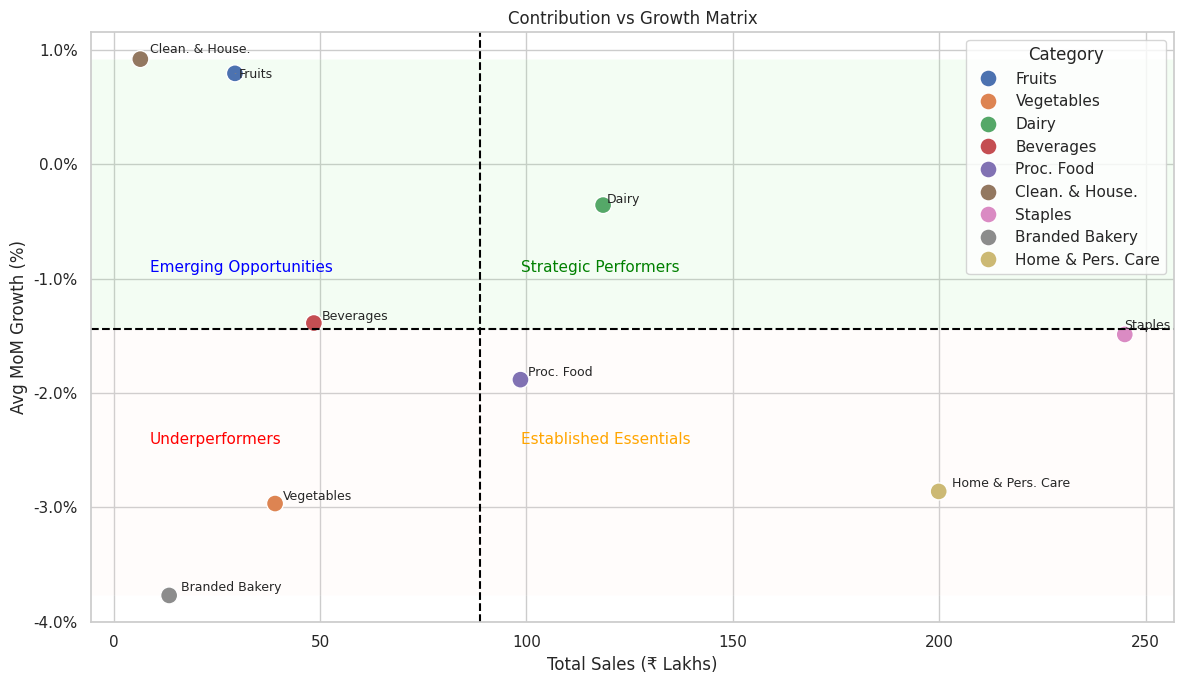

In [ ]:
# Figure 2- Product Category Performance Matrix

# categories and their corresponding sales columns
categories = [
    'Fruits', 'Vegetables', 'Dairy', 'Beverages', 'Proc. Food',
    'Clean. & House.', 'Staples', 'Branded Bakery', 'Home & Pers. Care'
]

sales_columns = [
    'Fruits Sales (₹ Lakhs)', 'Vegetables Sales (₹ Lakhs)', 'Dairy Sales (₹ Lakhs)',
    'Beverages Sales (₹ Lakhs)', 'Proc. Food Sales (₹ Lakhs)', 'Clean. & House. Sales (₹ Lakhs)',
    'Staples Sales (₹ Lakhs)', 'Branded Bakery Sales (₹ Lakhs)', 'Home & Pers. Care (₹ Lakhs)'
]


# MoM columns
mom_columns = [
    'MoM% Change-Fruits', 'MoM% Change-Vegetables', 'MoM% Change- Dairy',
    'MoM% Change- Beverages', 'MoM% Change- Proc. Food Sales', 'MoM% Change- Clean & House Sales',
    'MoM% Change- Staples Sales', 'MoM% Change- Branded Bakery', 'MoM% Change- Home & Pers. Care'
]

matrix_df = pd.DataFrame({
    'Category': categories,
    'Total Sales (₹ Lakhs)': [data[col].sum() for col in sales_columns],
    'Avg MoM Growth (%)': [data[col].mean() for col in mom_columns]
})

x_avg = matrix_df['Total Sales (₹ Lakhs)'].mean()
y_avg = matrix_df['Avg MoM Growth (%)'].mean()

plt.figure(figsize=(12, 7))

# Quadrant shading
plt.axhspan(ymin=y_avg, ymax=matrix_df['Avg MoM Growth (%)'].max(), facecolor='lightgreen', alpha=0.1)
plt.axhspan(ymin=matrix_df['Avg MoM Growth (%)'].min(), ymax=y_avg, facecolor='mistyrose', alpha=0.1)

# Main scatterplot
sns.scatterplot(data=matrix_df, x='Total Sales (₹ Lakhs)', y='Avg MoM Growth (%)', hue='Category', s=150)

# Quadrant lines
plt.axhline(y=y_avg, color='black', linestyle='--')
plt.axvline(x=x_avg, color='black', linestyle='--')

# Category labels
texts = [plt.text(row['Total Sales (₹ Lakhs)'], row['Avg MoM Growth (%)'], row['Category'], fontsize=9)
         for _, row in matrix_df.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Quadrant titles
plt.text(x_avg + 10, y_avg + 0.5, 'Strategic Performers', fontsize=11, color='green')
plt.text(x_avg - 80, y_avg + 0.5, 'Emerging Opportunities', fontsize=11, color='blue')
plt.text(x_avg + 10, y_avg - 1.0, 'Established Essentials', fontsize=11, color='orange')
plt.text(x_avg - 80, y_avg - 1.0, 'Underperformers', fontsize=11, color='red')

# Plot labels
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))

plt.title('Contribution vs Growth Matrix')
plt.xlabel('Total Sales (₹ Lakhs)')
plt.ylabel('Avg MoM Growth (%)')
plt.tight_layout()
plt.show()


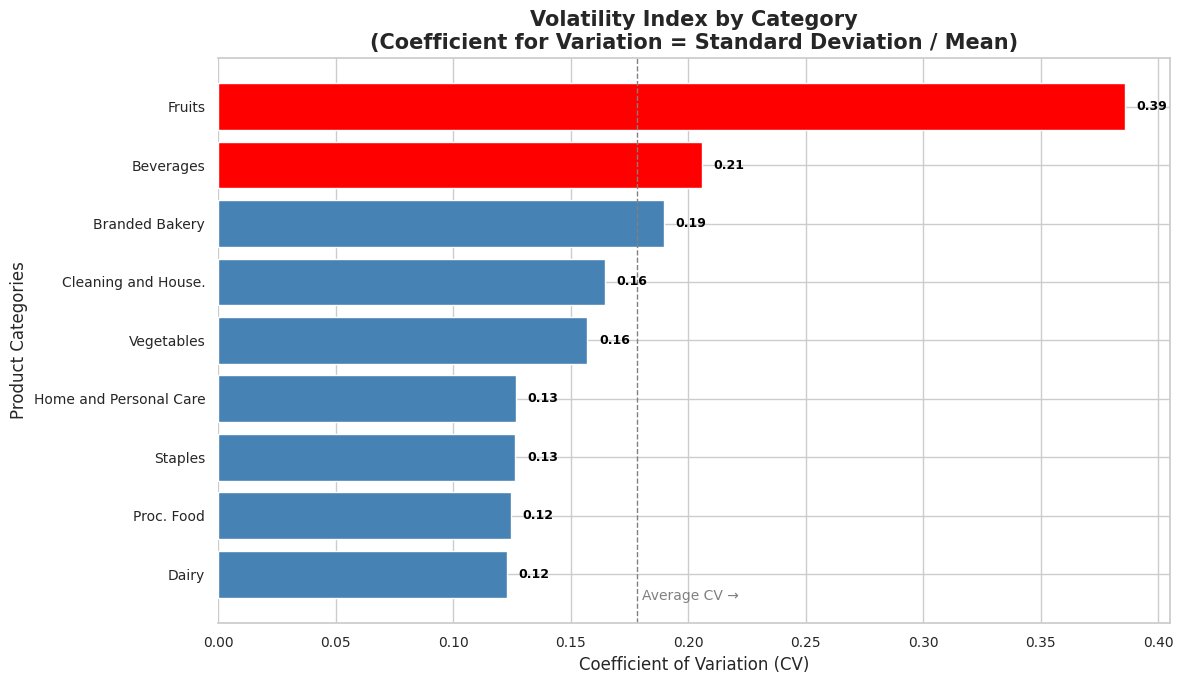


 Top 2 Most Volatile Categories:
• Fruits → CV: 0.39
• Beverages → CV: 0.21

 2 Most Stable Categories:
• Dairy → CV: 0.12
• Proc. Food → CV: 0.12


In [ ]:
# Figure 3- Sales Volatility by Category (CV)

# 1. Define categories and sales columns
category_names = [
    'Fruits', 'Vegetables', 'Dairy', 'Beverages', 'Proc. Food',
    'Clean. & House.', 'Staples', 'Branded Bakery', 'Home & Pers. Care'
]

sales_columns = [
    'Fruits Sales (₹ Lakhs)', 'Vegetables Sales (₹ Lakhs)', 'Dairy Sales (₹ Lakhs)',
    'Beverages Sales (₹ Lakhs)', 'Proc. Food Sales (₹ Lakhs)', 'Clean. & House. Sales (₹ Lakhs)',
    'Staples Sales (₹ Lakhs)', 'Branded Bakery Sales (₹ Lakhs)', 'Home & Pers. Care (₹ Lakhs)'
]

# 2. Computation of  CV (std / mean)
volatility = pd.Series(
    [data[col].std() / data[col].mean() for col in sales_columns],
    index=category_names
).sort_values()

# 3. Clean labels for better display
clean_index = [cat.replace("Pers.", "Personal").replace("Clean.", "Cleaning").replace("&", "and") for cat in volatility.index]

# 4. Plot
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

top_n = 2  # highlighting most volatile
colors = ['red' if cat in volatility.nlargest(top_n).index else 'steelblue' for cat in volatility.index]
bars = plt.barh(clean_index, volatility.values, color=colors)

# Axis titles
plt.title('Volatility Index by Category\n(Coefficient for Variation = Standard Deviation / Mean)', fontsize=15, fontweight='bold')
plt.xlabel('Coefficient of Variation (CV)', fontsize=12)
plt.ylabel('Product Categories', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 5. Annotating values on bars
for bar in bars:
    plt.text(bar.get_width() + 0.005,
             bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left',
             fontsize=9, fontweight='bold', color='black')

# 6. Reference Line for Average Coefficient for Variation
avg_cv = volatility.mean()
plt.axvline(avg_cv, color='gray', linestyle='--', linewidth=1)
plt.text(avg_cv + 0.002, -0.5, 'Average CV →', color='gray', fontsize=10, va='bottom')

plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.show()

# 7. Summary
print("\n Top 2 Most Volatile Categories:")
for cat in volatility.nlargest(2).index:
    print(f"• {cat} → CV: {volatility[cat]:.2f}")

print("\n 2 Most Stable Categories:")
for cat in volatility.nsmallest(2).index:
    print(f"• {cat} → CV: {volatility[cat]:.2f}")


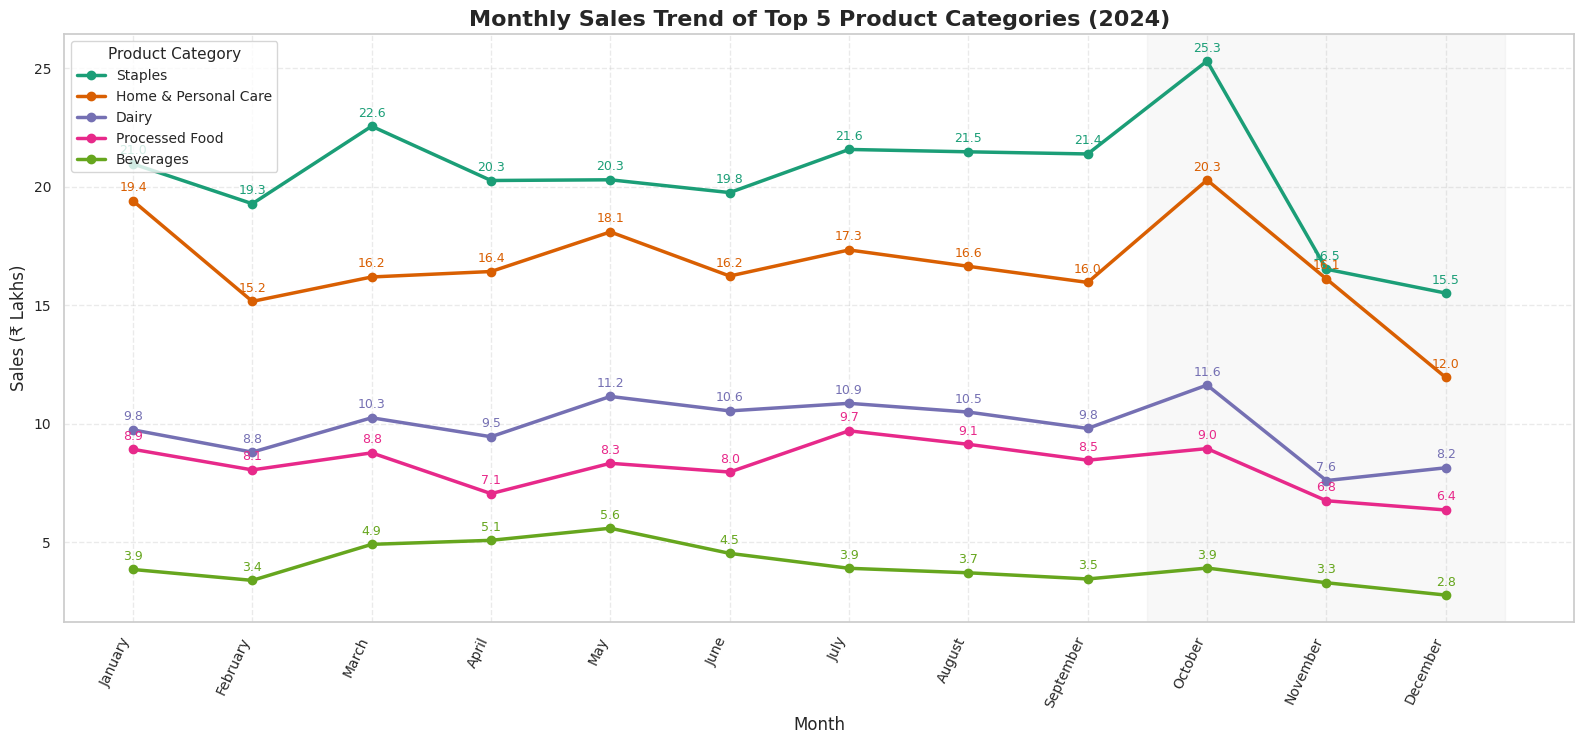

In [ ]:
# Figure 4- Seasonal Sales Trends for Top 5 Product Categories

# 1. Month order setup
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
data['Month'] = pd.Categorical(data['Month'], categories=month_order, ordered=True)
data = data.sort_values('Month')

# 2. Sales columns to plot
sales_cols = {
    'Staples': 'Staples Sales (₹ Lakhs)',
    'Home & Personal Care': 'Home & Pers. Care (₹ Lakhs)',
    'Dairy': 'Dairy Sales (₹ Lakhs)',
    'Processed Food': 'Proc. Food Sales (₹ Lakhs)',
    'Beverages': 'Beverages Sales (₹ Lakhs)'
}

# 3. Color palette
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']

# 4. Plot
plt.figure(figsize=(16, 8))
sns.set_theme(style='whitegrid')

for (label, col), color in zip(sales_cols.items(), colors):
    plt.plot(data['Month'], data[col], marker='o', label=label,
             linewidth=2.5, color=color)

    # Value annotations
    for x, y in zip(data['Month'], data[col]):
        if pd.notnull(y):
            plt.text(x, y + 0.4, f'{y:.1f}', ha='center', fontsize=9, color=color)

# Optional festive season highlight (Sept to Dec)
plt.axvspan(8.5, 11.5, color='gray', alpha=0.05)

# 5. Formatting
plt.title('Monthly Sales Trend of Top 5 Product Categories (2024)', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales (₹ Lakhs)', fontsize=12)
plt.xticks(rotation=65, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Product Category', fontsize=10, title_fontsize=11, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout(rect=[0, 0.05, 1, 1])

# 6. Optional Save
# plt.savefig("Top5_Sales_Trend_2024.png", dpi=300)

plt.show()


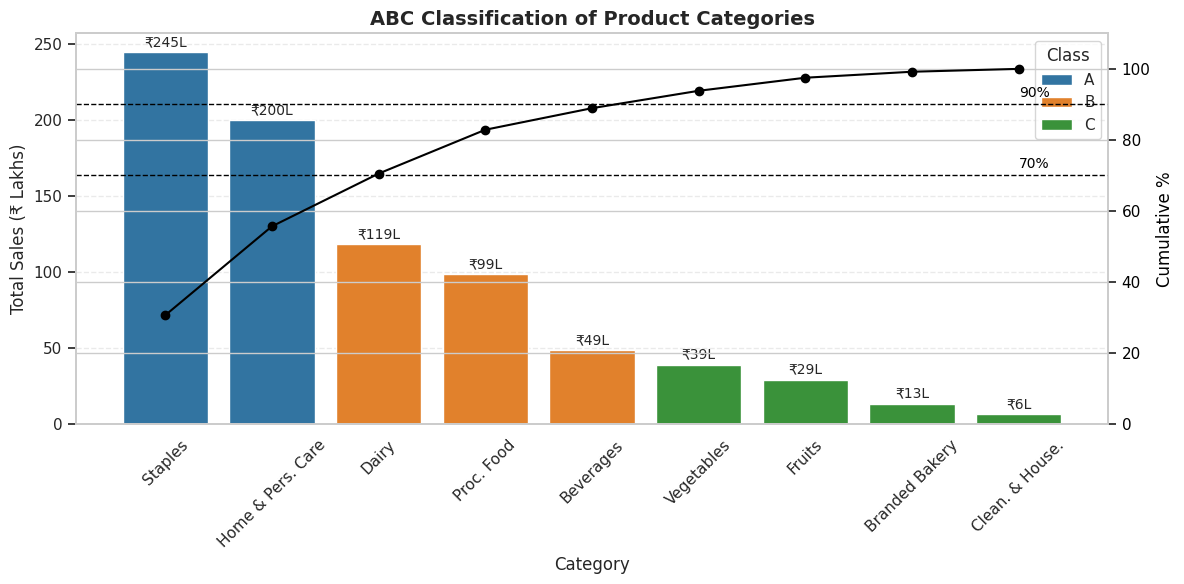

|    | Category          |   Total Sales (₹ Lakhs) | Class   |
|----|-------------------|-------------------------|---------|
|  0 | Staples           |                  244.96 | A       |
|  1 | Home & Pers. Care |                  199.88 | A       |
|  2 | Dairy             |                  118.57 | B       |
|  3 | Proc. Food        |                   98.55 | B       |
|  4 | Beverages         |                   48.5  | B       |
|  5 | Vegetables        |                   39.1  | C       |
|  6 | Fruits            |                   29.38 | C       |
|  7 | Branded Bakery    |                   13.44 | C       |
|  8 | Clean. & House.   |                    6.46 | C       |


In [ ]:
# Figure 5- Sales Contribution-Based ABC Classification

# 1. category names and sales columns
category_names = [
    'Fruits', 'Vegetables', 'Dairy', 'Beverages', 'Proc. Food',
    'Clean. & House.', 'Staples', 'Branded Bakery', 'Home & Pers. Care'
]

sales_columns = [
    'Fruits Sales (₹ Lakhs)', 'Vegetables Sales (₹ Lakhs)', 'Dairy Sales (₹ Lakhs)',
    'Beverages Sales (₹ Lakhs)', 'Proc. Food Sales (₹ Lakhs)', 'Clean. & House. Sales (₹ Lakhs)',
    'Staples Sales (₹ Lakhs)', 'Branded Bakery Sales (₹ Lakhs)', 'Home & Pers. Care (₹ Lakhs)'
]

# 2. Computation of total sales per category
category_sales = {cat: data[col].sum() for cat, col in zip(category_names, sales_columns)}

# 3. ABC Classification
abc_df = pd.DataFrame(list(category_sales.items()), columns=['Category', 'Total Sales (₹ Lakhs)'])
abc_df = abc_df.sort_values(by='Total Sales (₹ Lakhs)', ascending=False).reset_index(drop=True)
abc_df['Cumulative %'] = 100 * abc_df['Total Sales (₹ Lakhs)'].cumsum() / abc_df['Total Sales (₹ Lakhs)'].sum()

def classify(cum_pct):
    if cum_pct <= 70:
        return 'A'
    elif cum_pct <= 90:
        return 'B'
    else:
        return 'C'

abc_df['Class'] = abc_df['Cumulative %'].apply(classify)

# 4. ABC Bar + Pareto Plot
plt.figure(figsize=(12, 6))
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c'}
bars = sns.barplot(data=abc_df, x='Category', y='Total Sales (₹ Lakhs)', hue='Class', palette=palette, dodge=False)

for bar, value in zip(bars.patches, abc_df['Total Sales (₹ Lakhs)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"₹{value:.0f}L",
             ha='center', va='bottom', fontsize=10)

plt.title("ABC Classification of Product Categories", fontsize=14, fontweight='bold')
plt.xlabel("Category")
plt.ylabel("Total Sales (₹ Lakhs)")
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Pareto line
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(abc_df['Category'], abc_df['Cumulative %'], color='black', marker='o', linestyle='-', label='Cumulative %')
ax2.set_ylabel('Cumulative %', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 110)

# Horizontal ABC cutoff lines
ax2.axhline(70, color='black', linestyle='--', linewidth=1)
ax2.axhline(90, color='black', linestyle='--', linewidth=1)
ax2.text(len(abc_df)-1, 72, '70%', color='black', fontsize=10)
ax2.text(len(abc_df)-1, 92, '90%', color='black', fontsize=10)

plt.tight_layout()
plt.show()

# 5. ABC Table Output
abc_table = abc_df[['Category', 'Total Sales (₹ Lakhs)', 'Class']]
print(tabulate(abc_table, headers='keys', tablefmt='github'))


# Margin Behaviour and Profit-Volume Trade-offs

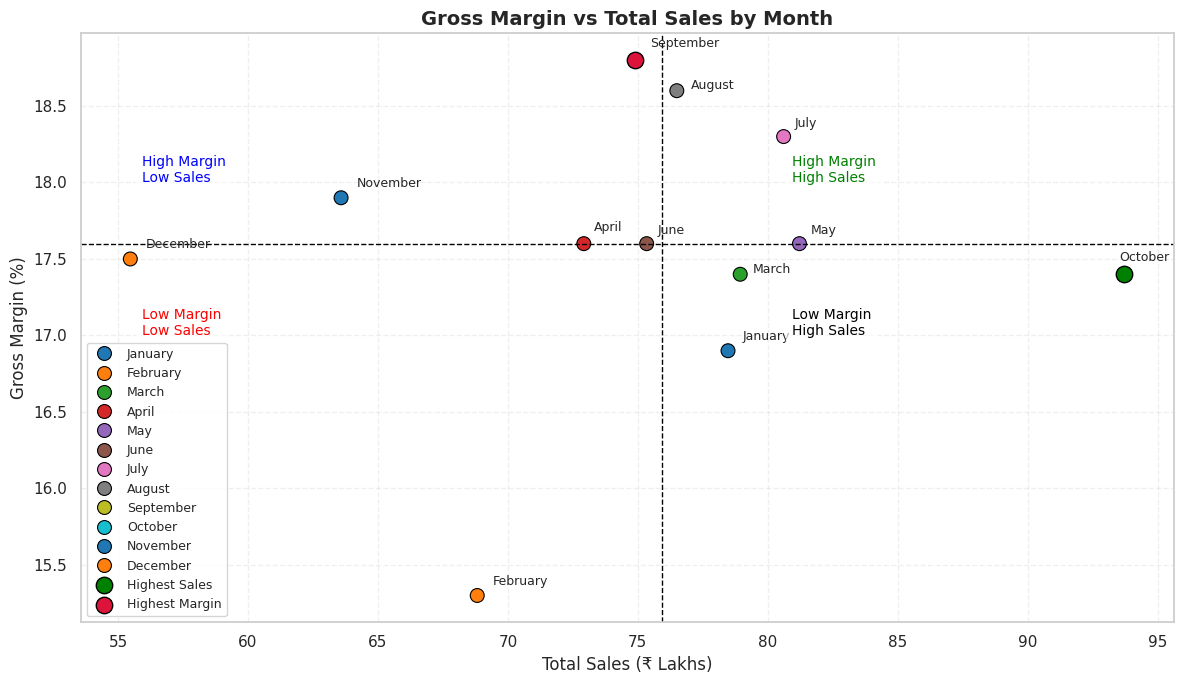

In [ ]:
# Figure 6- Margin vs Sales Quadrant

data['MonthIndex'] = pd.date_range(start='2024-01-01', periods=len(data), freq='MS')
data.set_index('MonthIndex', inplace=True)

# Calculation of Median Lines for Quadrant Segmentation
median_sales = data['Total Sales (₹ Lakhs)'].median()
median_margin = data['Gross Margin (%)'].median()

# Identification of Key Months for Highlighting
highest_sales_month = data.loc[data['Total Sales (₹ Lakhs)'].idxmax()]
highest_margin_month = data.loc[data['Gross Margin (%)'].idxmax()]

# Plot
plt.figure(figsize=(12, 7))
palette = sns.color_palette("tab10", len(data))

sns.scatterplot(
    data=data,
    x='Total Sales (₹ Lakhs)',
    y='Gross Margin (%)',
    hue='Month',
    palette=palette,
    s=100,
    edgecolor='black'
)

# Text Labels
texts = []
for i in range(data.shape[0]):
    x = data['Total Sales (₹ Lakhs)'].iloc[i]
    y = data['Gross Margin (%)'].iloc[i]
    label = data['Month'].iloc[i]
    texts.append(plt.text(x + 0.3, y + 0.05, label, fontsize=9))
adjust_text(texts)

# Highlighting Highest Sales & Highest Margin Months
plt.scatter(highest_sales_month['Total Sales (₹ Lakhs)'], highest_sales_month['Gross Margin (%)'],
            color='green', edgecolor='black', s=140, label='Highest Sales')
plt.scatter(highest_margin_month['Total Sales (₹ Lakhs)'], highest_margin_month['Gross Margin (%)'],
            color='crimson', edgecolor='black', s=140, label='Highest Margin')

# Addition of  Median Reference Lines
plt.axvline(x=median_sales, color='black', linestyle='--', linewidth=1)
plt.axhline(y=median_margin, color='black', linestyle='--', linewidth=1)

# Quadrant Labels
plt.text(median_sales + 5, median_margin + 0.4, 'High Margin\nHigh Sales', color='green', fontsize=10,bbox=dict(facecolor='white', alpha=0.6))
plt.text(median_sales - 20, median_margin + 0.4, 'High Margin\nLow Sales', color='blue', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.text(median_sales - 20, median_margin - 0.6, 'Low Margin\nLow Sales', color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.text(median_sales + 5, median_margin - 0.6, 'Low Margin\nHigh Sales', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

# Plot
plt.title('Gross Margin vs Total Sales by Month', fontsize=14, fontweight='bold')
plt.xlabel('Total Sales (₹ Lakhs)', fontsize=12)
plt.ylabel('Gross Margin (%)', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
summary = data[['Month', 'Total Sales (₹ Lakhs)', 'Gross Margin (%)']].copy()
summary = summary.sort_values('Total Sales (₹ Lakhs)', ascending=False)
print("\n Sales vs Margin by Month:")
print(summary.to_string(index=False))



 Sales vs Margin by Month:
    Month  Total Sales (₹ Lakhs)  Gross Margin (%)
  October                  93.72              17.4
      May                  81.22              17.6
     July                  80.61              18.3
    March                  78.94              17.4
  January                  78.47              16.9
   August                  76.50              18.6
     June                  75.34              17.6
September                  74.89              18.8
    April                  72.92              17.6
 February                  68.82              15.3
 November                  63.58              17.9
 December                  55.47              17.5


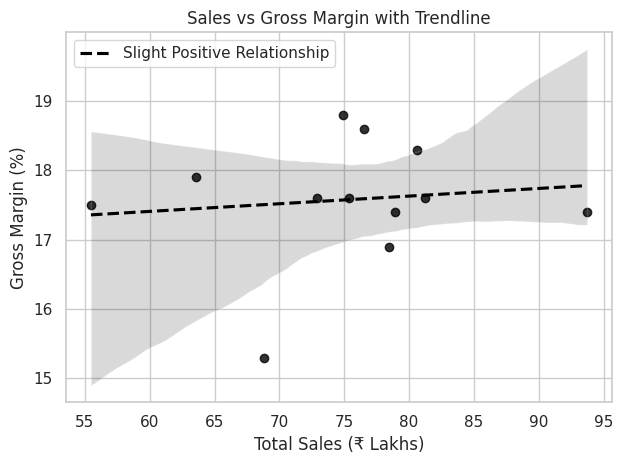

In [ ]:
# Figure 7- Sales vs Gross Margin - Regression Analysis

# Regression Trendline
sns.regplot(
    data=data,
    x='Total Sales (₹ Lakhs)',
    y='Gross Margin (%)',
    scatter=True,
    color='black',
    line_kws={"linestyle": "dashed", "label": "Slight Positive Relationship"}
)

plt.legend()

plt.xlabel("Total Sales (₹ Lakhs)")
plt.ylabel("Gross Margin (%)")
plt.title("Sales vs Gross Margin with Trendline")
plt.grid(True)
plt.tight_layout()
plt.show()


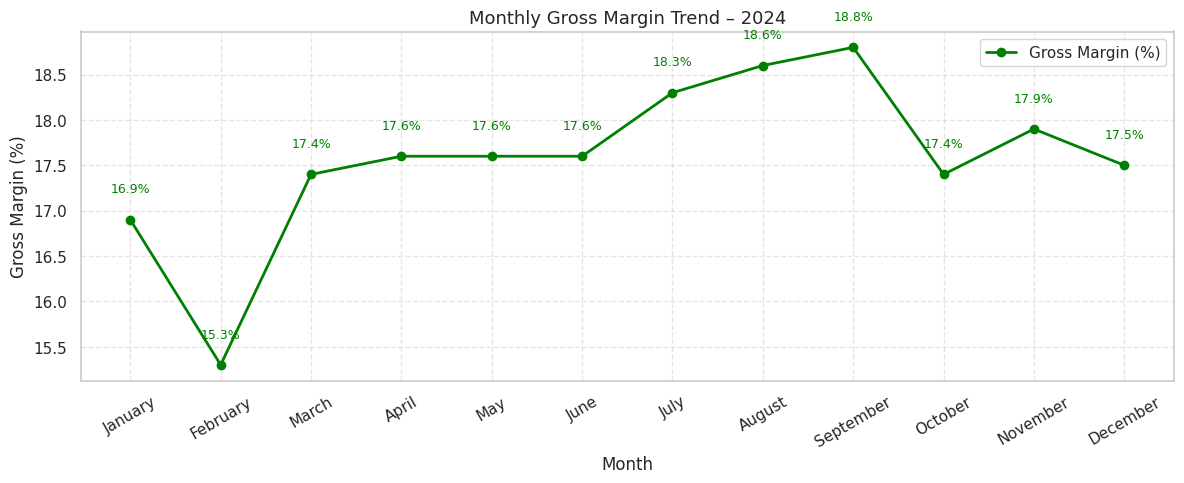

In [ ]:
# Figure 8- Gross Margin Trend (2024)

# Define months and gross margin values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
gross_margin = [16.9, 15.3, 17.4, 17.6, 17.6, 17.6, 18.3, 18.6, 18.8, 17.4, 17.9, 17.5]

# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(months, gross_margin, marker='o', color='green', linestyle='-', linewidth=2, label='Gross Margin (%)')

# Annotate each point
for i, val in enumerate(gross_margin):
    plt.text(i, val + 0.3, f'{val:.1f}%', ha='center', fontsize=9, color='green')

# Format the plot
plt.title("Monthly Gross Margin Trend – 2024", fontsize=13)
plt.xlabel("Month")
plt.ylabel("Gross Margin (%)")
plt.xticks(rotation=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()


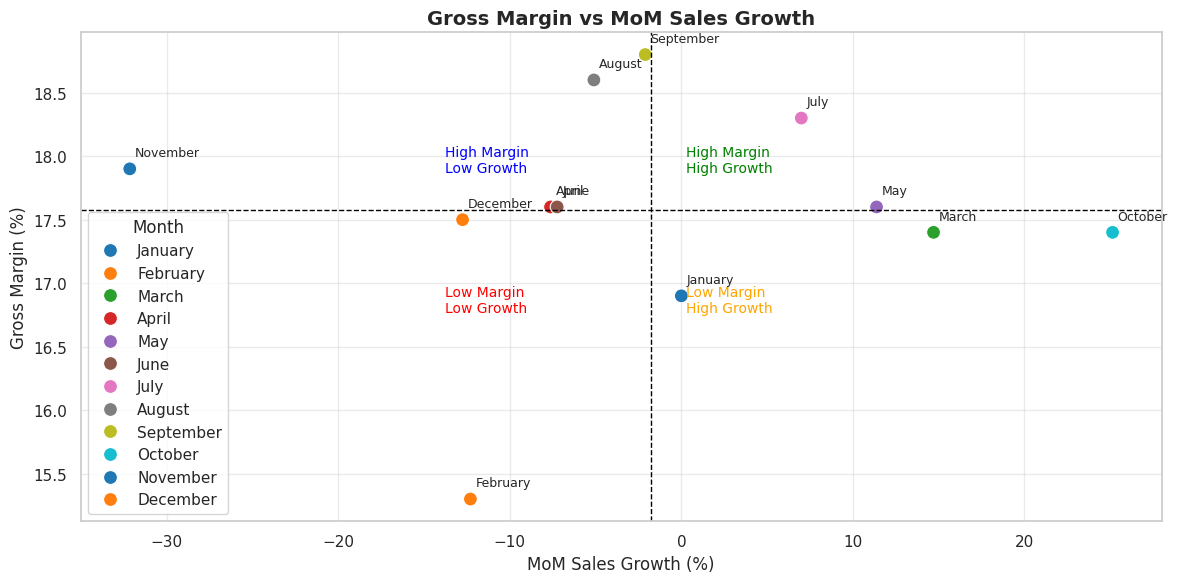

In [ ]:
# Figure 9- Monthly Margin vs Growth Correlation

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.scatterplot(
    x=data['MoM% Change-Total Sales'],
    y=data['Gross Margin (%)'],
    hue=data['Month'],
    palette='tab10',
    s=100
)

# Adding quadrant reference lines
x_avg = data['MoM% Change-Total Sales'].mean()
y_avg = data['Gross Margin (%)'].mean()

plt.axhline(y=y_avg, color='black', linestyle='--', linewidth=1)
plt.axvline(x=x_avg, color='black', linestyle='--', linewidth=1)

# Annotating points
for i in range(len(data)):
    x = data['MoM% Change-Total Sales'].iloc[i]
    y = data['Gross Margin (%)'].iloc[i]
    label = data['Month'].iloc[i]
    plt.text(x + 0.3, y + 0.1, label, fontsize=9)

# Quadrant names
plt.text(x_avg + 2, y_avg + 0.3, 'High Margin\nHigh Growth', fontsize=10, color='green')
plt.text(x_avg - 12, y_avg + 0.3, 'High Margin\nLow Growth', fontsize=10, color='blue')
plt.text(x_avg - 12, y_avg - 0.8, 'Low Margin\nLow Growth', fontsize=10, color='red')
plt.text(x_avg + 2, y_avg - 0.8, 'Low Margin\nHigh Growth', fontsize=10, color='orange')

plt.title("Gross Margin vs MoM Sales Growth", fontsize=14, weight='bold')
plt.xlabel("MoM Sales Growth (%)")
plt.ylabel("Gross Margin (%)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


# Customer Growth and Margin Sensitivity

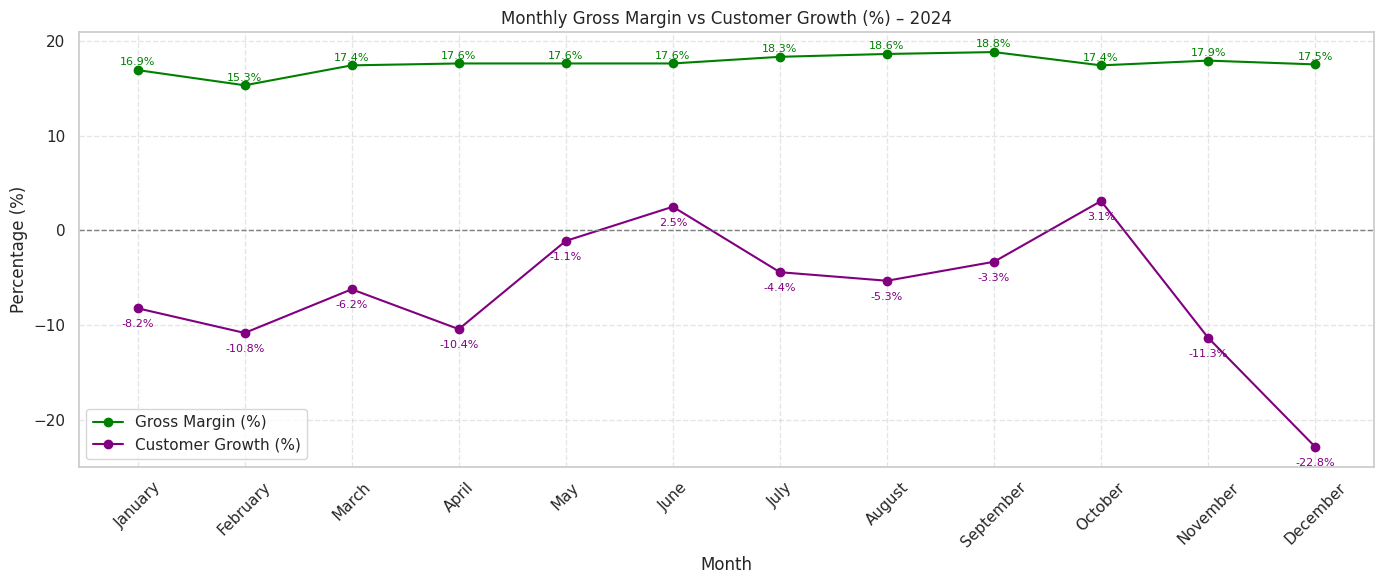

In [ ]:
# Figure 10- Customer Growth vs Gross Margin (%)

months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Example data (replace with your real lists if stored in DataFrame)
gross_margin = [16.9, 15.3, 17.4, 17.6, 17.6, 17.6, 18.3, 18.6, 18.8, 17.4, 17.9, 17.5]
customer_growth = [-8.2, -10.8, -6.2, -10.4, -1.1, 2.5, -4.4, -5.3, -3.3, 3.1, -11.3, -22.8]

plt.figure(figsize=(14, 6))

plt.plot(months, gross_margin, marker='o', color='green', label='Gross Margin (%)')
plt.plot(months, customer_growth, marker='o', color='purple', label='Customer Growth (%)')

for i, val in enumerate(gross_margin):
    plt.text(i, val + 0.5, f'{val:.1f}%', ha='center', fontsize=8, color='green')
for i, val in enumerate(customer_growth):
    plt.text(i, val - 2, f'{val:.1f}%', ha='center', fontsize=8, color='purple')

plt.title('Monthly Gross Margin vs Customer Growth (%) – 2024')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Inventory Holding and Perishability Risk

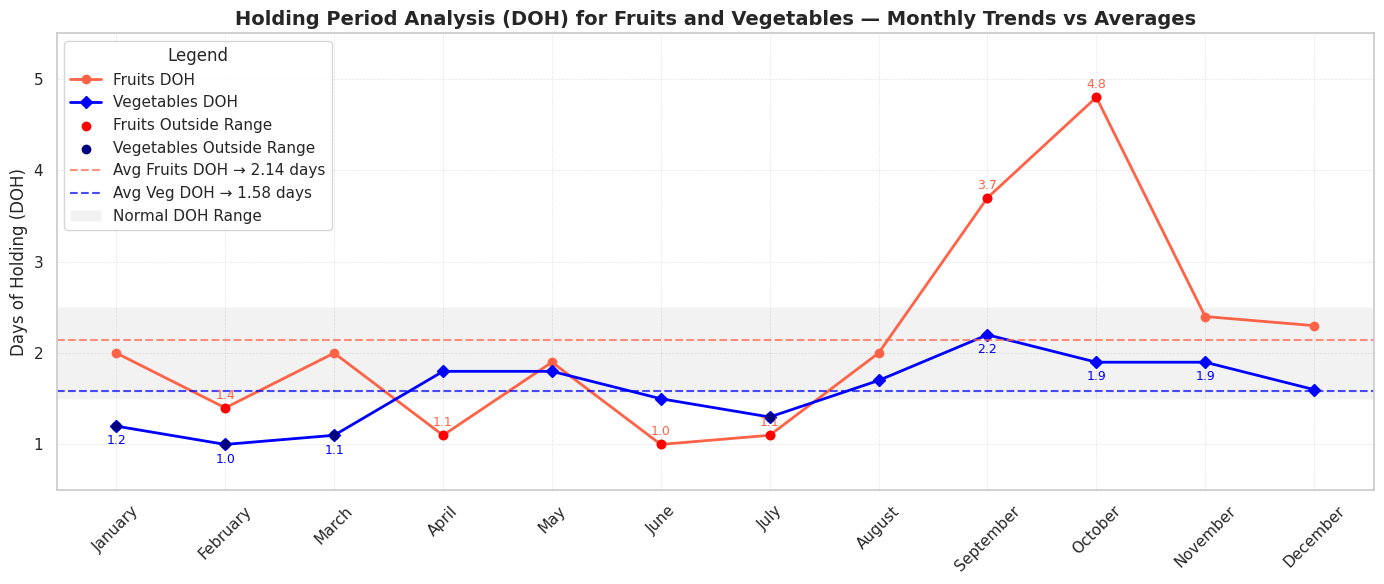

In [ ]:
# Figure 11- Monthly Days of Holding (DOH) for Fruits & Vegetables

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
data['Month'] = pd.Categorical(data['Month'], categories=month_order, ordered=True)
data = data.sort_values('Month')

# Calculating averages ---
avg_doh_fruits = data['DOH- Fruits (Days)'].mean()
avg_doh_vegetables = data['DOH- Vegetables (Days)'].mean()

# Plot
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Main DOH trend lines
plt.plot(data['Month'], data['DOH- Fruits (Days)'], label='Fruits DOH', marker='o', color='tomato', linewidth=2)
plt.plot(data['Month'], data['DOH- Vegetables (Days)'], label='Vegetables DOH', marker='D', color='blue', linewidth=2)

# Highlighting points outside normal range (Fruits)
fruits_out = data[(data['DOH- Fruits (Days)'] > 2.5) | (data['DOH- Fruits (Days)'] < 1.5)]
plt.scatter(fruits_out['Month'], fruits_out['DOH- Fruits (Days)'], color='red', label='Fruits Outside Range', zorder=5)

# Highlighting points outside normal range (Vegetables)
veg_out = data[(data['DOH- Vegetables (Days)'] > 2.5) | (data['DOH- Vegetables (Days)'] < 1.5)]
plt.scatter(veg_out['Month'], veg_out['DOH- Vegetables (Days)'], color='navy', label='Vegetables Outside Range', zorder=5)

# Average lines
plt.axhline(y=avg_doh_fruits, linestyle='--', color='tomato', alpha=0.7, linewidth=1.5,
            label=f'Avg Fruits DOH → {avg_doh_fruits:.2f} days')
plt.axhline(y=avg_doh_vegetables, linestyle='--', color='blue', alpha=0.7, linewidth=1.5,
            label=f'Avg Veg DOH → {avg_doh_vegetables:.2f} days')

# Normal DOH shaded range
plt.axhspan(1.5, 2.5, facecolor='gray', alpha=0.1, label='Normal DOH Range')

# Annotation of spikes for fruits
for i, val in enumerate(data['DOH- Fruits (Days)']):
    if val > avg_doh_fruits + 0.3 or val < avg_doh_fruits - 0.3:
        plt.text(i, val + 0.1, f"{val:.1f}", ha='center', color='tomato', fontsize=9)

# Annotation of spikes for vegetables
for i, val in enumerate(data['DOH- Vegetables (Days)']):
    if val > avg_doh_vegetables + 0.3 or val < avg_doh_vegetables - 0.3:
        plt.text(i, val - 0.2, f"{val:.1f}", ha='center', color='blue', fontsize=9)


plt.title("Holding Period Analysis (DOH) for Fruits and Vegetables — Monthly Trends vs Averages",
          fontsize=14, fontweight='bold')
plt.ylabel("Days of Holding (DOH)")
plt.xticks(rotation=45)
plt.ylim(0.5, max(data[['DOH- Fruits (Days)', 'DOH- Vegetables (Days)']].max()) + 0.7)
plt.legend(title="Legend")
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


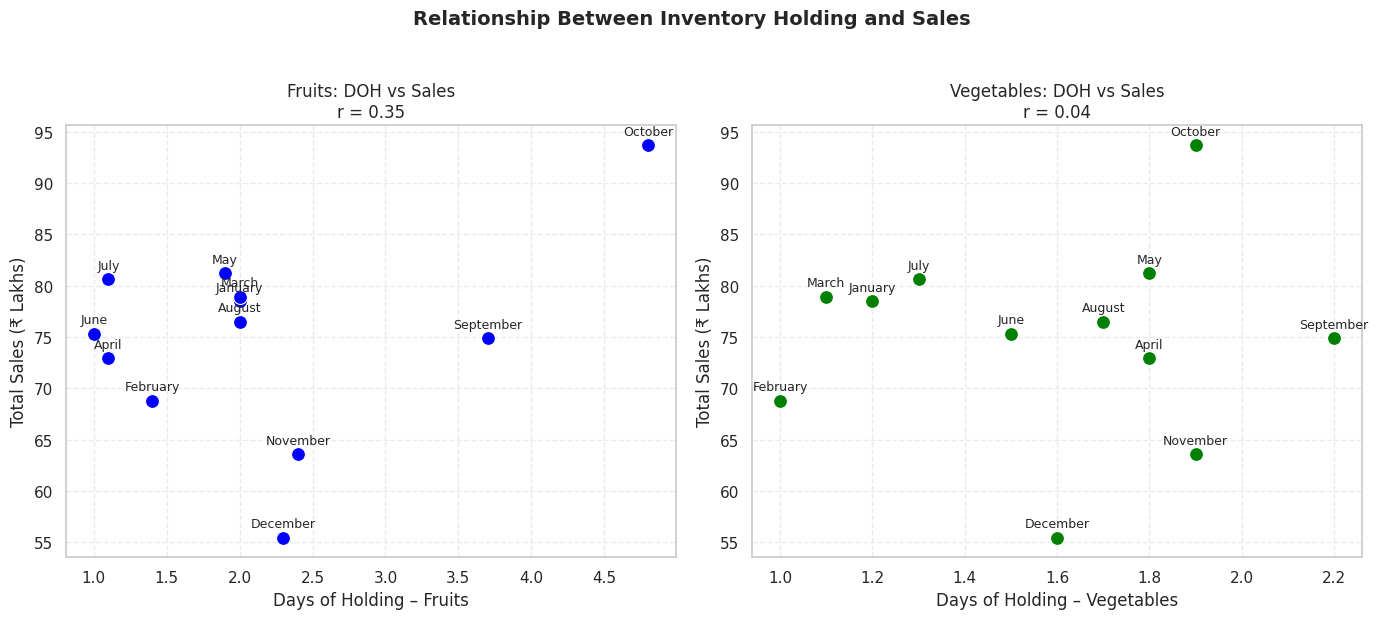

In [ ]:
# Figure 12- DOH and Sales Relationship

data['DOH- Fruits (Days)'] = pd.to_numeric(data['DOH- Fruits (Days)'], errors='coerce')
data['DOH- Vegetables (Days)'] = pd.to_numeric(data['DOH- Vegetables (Days)'], errors='coerce')
data['Total Sales (₹ Lakhs)'] = pd.to_numeric(data['Total Sales (₹ Lakhs)'], errors='coerce')


plot_df = data.dropna(subset=['DOH- Fruits (Days)', 'DOH- Vegetables (Days)', 'Total Sales (₹ Lakhs)', 'Month'])

# Correlation coefficients
corr_fruits, _ = pearsonr(plot_df['DOH- Fruits (Days)'], plot_df['Total Sales (₹ Lakhs)'])
corr_veg, _ = pearsonr(plot_df['DOH- Vegetables (Days)'], plot_df['Total Sales (₹ Lakhs)'])

plt.figure(figsize=(14, 6))
plt.suptitle("Relationship Between Inventory Holding and Sales", fontsize=14, fontweight='bold', y=1.03)

# Fruits subplot
plt.subplot(1, 2, 1)
sns.scatterplot(data=plot_df, x='DOH- Fruits (Days)', y='Total Sales (₹ Lakhs)', color='blue', s=100)
for i, row in plot_df.iterrows():
    plt.text(row['DOH- Fruits (Days)'], row['Total Sales (₹ Lakhs)']+1, row['Month'], fontsize=9, ha='center')

plt.title(f'Fruits: DOH vs Sales\nr = {corr_fruits:.2f}')
plt.xlabel('Days of Holding – Fruits')
plt.ylabel('Total Sales (₹ Lakhs)')
plt.grid(True, linestyle='--', alpha=0.4)

# Vegetables subplot
plt.subplot(1, 2, 2)
sns.scatterplot(data=plot_df, x='DOH- Vegetables (Days)', y='Total Sales (₹ Lakhs)', color='green', s=100)
for i, row in plot_df.iterrows():
    plt.text(row['DOH- Vegetables (Days)'], row['Total Sales (₹ Lakhs)']+1, row['Month'], fontsize=9, ha='center')

plt.title(f'Vegetables: DOH vs Sales\nr = {corr_veg:.2f}')
plt.xlabel('Days of Holding – Vegetables')
plt.ylabel('Total Sales (₹ Lakhs)')
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


# Stock Availability and Revenue Continuity

/tmp/ipython-input-72-472407958.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=avg_availability.values, y=clean_labels, palette=colors)


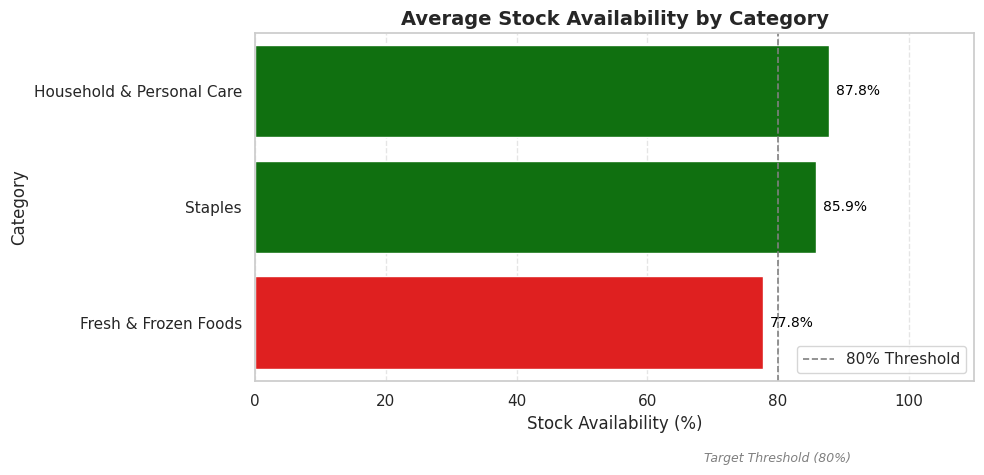

In [ ]:

# Figure 13- Category-Wise Stock Availability vs Service Benchmark

# Stock availability columns
stock_cols = [
    'Stock Availability - Staples (%)',
    'Stock Availability - Household & Personal Care (%)',
    'Stock Availability - Fresh & Frozen Foods (%)'
]

# Step 2: Computating average availability
avg_availability = data[stock_cols].mean().sort_values(ascending=False)

clean_labels = avg_availability.index.str.replace('Stock Availability - ', '', regex=False)
clean_labels = clean_labels.str.replace(' (%)', '', regex=False)

# Identifying categories with risk
colors = ['green' if val >= 80 else 'red' for val in avg_availability.values]

plt.figure(figsize=(10, 5))
bars = sns.barplot(x=avg_availability.values, y=clean_labels, palette=colors)

# Annotating each bar
for i, val in enumerate(avg_availability.values):
    plt.text(val + 1, i, f"{val:.1f}%", va='center', fontsize=10, color='black')

# Thresshold line
plt.axvline(x=80, color='gray', linestyle='--', linewidth=1.2, label='80% Threshold')
#plt.text(80.5, len(avg_availability) - 0.5, 'Minimum Target', color='gray', fontsize=9)
plt.text(80, len(avg_availability) + 0.2, 'Target Threshold (80%)',
         color='gray', fontsize=9, ha='center', fontstyle='italic')


plt.title("Average Stock Availability by Category", fontsize=14, weight='bold')
plt.xlabel("Stock Availability (%)")
plt.ylabel("Category")
plt.xlim(0, 110)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-73-1069270235.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(x[i], y[i], data['Month'].iloc[i], fontsize=9))
/tmp/ipython-input-73-1069270235.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(x[i], y[i], data['Month'].iloc[i], fontsize=9))
/tmp/ipython-input-73-1069270235.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(x[i], y[i], data['M

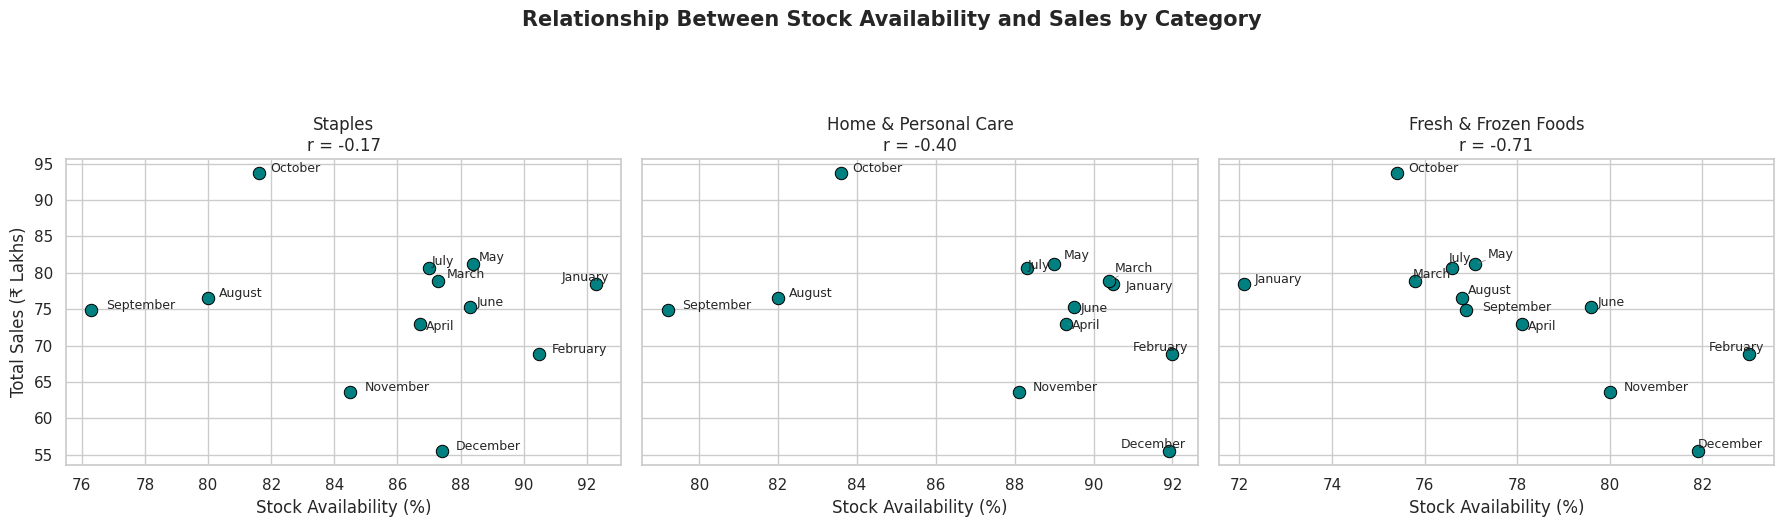

In [ ]:
# Figure 14- Stock Availability Impact on Total Sales

# Category-specific availability columns
availability_cols = {
    'Staples': 'Stock Availability - Staples (%)',
    'Home & Personal Care': 'Stock Availability - Household & Personal Care (%)',
    'Fresh & Frozen Foods': 'Stock Availability - Fresh & Frozen Foods (%)'
}

# Subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle("Relationship Between Stock Availability and Sales by Category",
             fontsize=15, fontweight='bold', y=1.05)


for ax, (category, col_name) in zip(axes, availability_cols.items()):
    x = data[col_name]
    y = data['Total Sales (₹ Lakhs)']

    # Correlation coefficient
    r = x.corr(y)

    sns.scatterplot(x=x, y=y, ax=ax, s=80, color='teal', edgecolor='black')

    # Annotating months
    texts = []
    for i in range(len(data)):
        texts.append(ax.text(x[i], y[i], data['Month'].iloc[i], fontsize=9))
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    ax.set_title(f"{category}\nr = {r:.2f}", fontsize=12)
    ax.set_xlabel("Stock Availability (%)")
    ax.set_ylabel("Total Sales (₹ Lakhs)" if ax == axes[0] else "")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
